In [2]:
#importing 
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import trange
from tqdm import tqdm


In [19]:
#importing the dataset using tinygrad
from tinygrad.nn.datasets import mnist
#mnist() returns four tensors
X_train, Y_train, X_test, Y_test = mnist()
#converting into numpy
X_train = X_train.reshape(-1, 784).numpy().astype(np.float32)
Y_train = Y_train.numpy().astype(np.int8)
X_test = X_test.reshape(-1, 784).numpy().astype(np.float64)
Y_test = Y_test.numpy().astype(np.int8)
print(X_train.shape, X_train.dtype, Y_train.shape, Y_train.dtype)

(60000, 784) float32 (60000,) int8


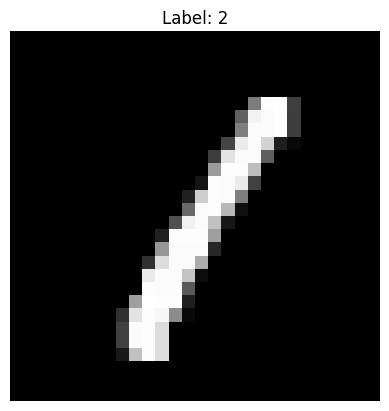

In [5]:
from matplotlib import pyplot as plt

def imshow(image, label):
    plt.imshow(image.reshape(28, 28), cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()

imshow(X_train[3].astype(float), int(Y_train[5].item()))

In [6]:
#initializing the model
class CNet(nn.Module):
    def __init__(self):
        super(CNet, self).__init__()
        self.l1 = nn.Linear(784, 128)
        self.l2 = nn.Linear(128, 10)
        self.sm = nn.LogSoftmax(dim=None)
    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        x = self.sm(x)
        return x
        

In [8]:
from tqdm import tqdm
#aining the model
model = CNet()
lossfunction = nn.CrossEntropyLoss()
optimizer =torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)
BS = 128
epochs = 1000
#list to store the accuracies and losses will later plot it
losses = []
accuracies = []
# Uing tqdm's trange for the progress bar
progress_bar = tqdm(total=epochs, desc='Training Progress')
for i in trange(epochs):
    sample = np.random.randint(0,X_train.shape[0],size=(BS))

    #converting into pytorch tensors
    X = torch.tensor(X_train[sample].reshape((-1, 28*28))).float()
    Y = torch.tensor(Y_train[sample]).long()

    #making the gradient zero
    optimizer.zero_grad() 
    
    out = model(X)

    #calculating the accuracy
    cat = torch.argmax(out, dim=1)
    accuracy = (cat == Y).float().mean()

    
    loss = lossfunction(out, Y)
    loss = loss.mean()
    loss.backward()

    
    optimizer.step()
    
    # loss, accuracy = loss.item(), accuracy.item()
    losses.append(loss)
    accuracies.append(accuracy)
    # to show the epochs : tqdm.write(f'Epoch [{i+1}/{epochs}], Loss: {loss.item():.2f}, Accuracy: {accuracy:.2f}')
    progress_bar.set_description(f'Loss: {loss:.2f}, Accuracy: {accuracy:.2f}')




100%|██████████| 1000/1000 [00:02<00:00, 469.41it/s]


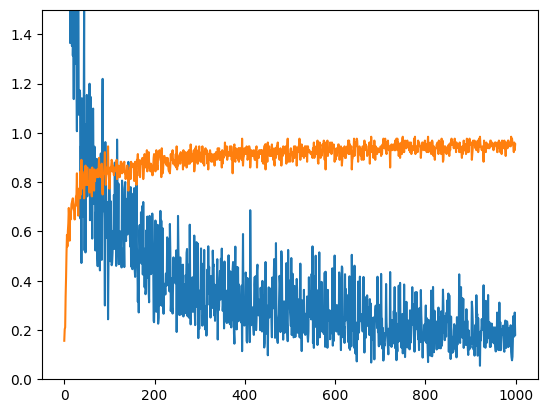

In [9]:
#plotting the graph 
from matplotlib.pyplot import plot
losses_tensor = torch.tensor(losses)
accuracies_tensor = torch.tensor(accuracies)

plt.ylim(0, 1.5)
plot(losses_tensor.detach().numpy())
plot(accuracies_tensor.detach().numpy())

# you can see the loss is decreasing then the accuracy is increasing

### checking the model with numpy

In [29]:
#we will copy the weights from the pytorch nn
w1 = model.l1.weight.detach().numpy().T #.astype(np.float64)
w2 = model.l2.weight.detach().numpy().T #.astype(np.float64)

In [30]:
# we will do forward pass using numpy
# in this model we have not used bias so we are doing it with weights only
def forward(x):
    x = x.reshape(-1, 784) #Reshape the input x to have 784 features
    x = x.dot(w1)# Perform matrix multiplication between x and w1 (first layer weights)
    x = np.maximum(0,x)#Apply the ReLU activation function element-wise
    x = x.dot(w2) # Perform matrix multiplication between the activated output and w2 (second layer weights)
    return x

In [31]:
#we will check the sanity of the model with numpy
pred = forward(X_test).argmax(axis=1)
accuracy = (pred == Y_test).mean()
print(f"test set accuracy is {accuracy}")

test set accuracy is 0.9372


### solving with numpy